# estimation and confidence intervals

> An important part of data science consists of making conclusions based on the data in random samples. [source](https://www.inferentialthinking.com/chapters/10/Sampling_and_Empirical_Distributions.html)

In [1]:
using DataFrames
using CSV
using StatsBase
using PyPlot
using Statistics # for mean, percentile

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

## a random sample of Airbnb's

> with high probability, the empirical distribution of a large random sample will resemble the distribution of the population from which the sample was drawn. [source](https://www.inferentialthinking.com/chapters/10/3/Empirical_Distribution_of_a_Statistic.html)


**empirical distribution**: the distribution of observed data, often visualized by a histogram

> A statistic (note the singular!) is any number computed using the data in a sample. The sample median, therefore, is a statistic. [source](https://www.inferentialthinking.com/chapters/10/3/Empirical_Distribution_of_a_Statistic.html#Statistic)

`listings.csv` contains data on the *entire population* of Airbnb's in Seattle [[source](https://www.kaggle.com/airbnb/seattle#listings.csv)]. each row represents an Airbnb rental, and the `:price` column contains the price of the Airbnb.

In [2]:
df = CSV.read("listings.csv", copycols=true)
first(df, 6)

,id,listing_url,scrape_id,last_scraped,name
,Int64,String,Int64,Dates…,String
1,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment
2,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment
3,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view
4,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau
5,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house
6,5956968,https://www.airbnb.com/rooms/5956968,20160104002432,2016-01-04,Private unit in a 1920s mansion


how many Airbnb's are listed in Seattle?

In [3]:
num_listings = length(unique(df[!, :id]))

3818

look at the `:price` column. `CSV.jl` was unable to convert these to `Float64`s and instead kept them as `String`s.

In [4]:
df[!, :price][1:6]

6-element PooledArrays.PooledArray{String,UInt32,1,Array{UInt32,1}}:
 "\$85.00" 
 "\$150.00"
 "\$975.00"
 "\$100.00"
 "\$450.00"
 "\$120.00"

if we try to `parse` them as `Float64`'s, we see the problem: there are dollar signs in the prices!

now let's remove the dollar signs from the strings using the `replace` command. 

In [5]:
# note: he did this in multiple lines and used parse.(stuff)
df[!, :price] = map(val -> parse(
        Float64, 
        replace(replace(val, "\$" => ""), "," => "")
    ),
    df[!, :price]
)
df[!, :price][1:6]

6-element PooledArrays.PooledArray{Float64,UInt32,1,Array{UInt32,1}}:
  85.0
 150.0
 975.0
 100.0
 450.0
 120.0

great, dollar signs are successfully removed. now let's convert to `Float64`s so we can look at the mean price.

still not there, the commas are causing trouble.

In [6]:
# jk lol I one lined it up there

now that the `:price` column is properly converted to `Float64`s, we can compute the mean price of an Airbnb in Seattle. note this is the population mean since this list is of *all* Airbnbs in Seattle, obtained via scraping the Airbnb website at a given time.

In [34]:
pop_mean = mean(df[!, :price])
mean(df[!, :price]), median(df[!, :price])

(127.97616553169199, 100.0)

plot the distribution of the Airbnb prices in Seattle.

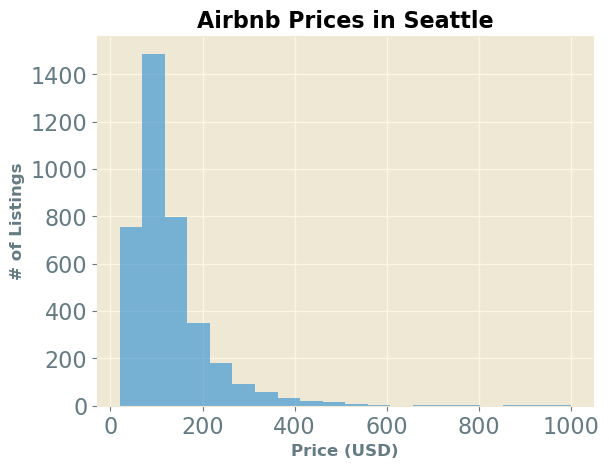

In [13]:
figure()
hist(df[!, :price], alpha=0.6, bins=20)
title("Airbnb Prices in Seattle", weight="bold")
xlabel("Price (USD)", weight="bold")
ylabel("# of Listings", weight="bold");

now let's take a *random sample* of the population of Airbnb's in Seattle and look at the *empirical distribution* of price based on this random sample. in practice, one takes a *random sample* from a population because taking a measurement on the *entire* population is usually prohibitively expensive and time-consuming.

In [9]:
num_samples = 300
ids_sampled_airbnbs = sample(1:num_listings, num_samples, replace=false)
sampled_prices = df[ids_sampled_airbnbs, :price];

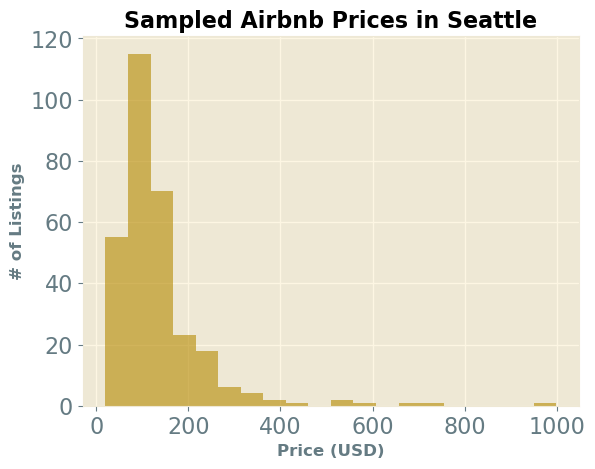

In [19]:
figure()
hist(sampled_prices, alpha=0.6, bins=20, color="C3")
title("Sampled Airbnb Prices in Seattle", weight="bold")
xlabel("Price (USD)", weight="bold")
ylabel("# of Listings", weight="bold");

indeed (most likely), the empirical histogram (from the random sample) resembles the distribution from the entire population. this is what justifies making conclusions about a *population* from a *random sample* of it, i.e. this is what justifies *statistical inference*! of course, (i) the empirical distribution from the random sample is more likely to closely resemble the distribution of the population if the random sample is large and (ii) there is an uncertainty associated with conclusions based on the random sample, since there is a possibility that the empirical distribution of the random sample differs significantly from the distribution of the population--especially if the sample size is small.

## estimation: point estimates, interval estimates and confidence intervals via bootstrap

we aim to use the data from a random sample to *estimate* an unknown parameter of a population and quantify our uncertainty. here, we'll estimate the mean price of the Airbnb's in Seattle from the random sample we took and obtain a confidence interval via a powerful technique called bootstrapping [alternative resource here](https://www.inferentialthinking.com/chapters/13/2/Bootstrap.html). for our own academic satisfaction, we can compare to the actual mean price of the population that we computed above, `mean_airbnb_price`. but, consider, in real life, we do not know the actual mean of the population with which to compare.

first, let's compute the estimated mean Airbnb price from our random sample.

In [29]:
actual_sample_mean = mean(sampled_prices)

134.14

the sample mean differs from the population mean, but is close!

**important**: if, in the random sampling, we had chosen a different set of Airbnb's by chance, our estimated mean would be different.

so to quantify uncertainty in our current estimate of the mean price from our sample, we should address the question of how the estimated mean could differ from random sample to random sample.

we can approximate the empirical distribution of the mean Seattle Airbnb price among possible random samples of this size via **bootstrapping**, a powerful method based on resampling. we can think of bootstrapping as approximately simulating the process of collecting a random sample from the population.

the main idea is that we can **simulate a random sample of the population by collecting a random sample from the sample**. 
* this random sample of the sample must be the same size as the sample, since the number of samples affects the estimate
* this sampling must be done with replacement (otherwise, we'd get the sample back)

essentially, we are treating the random sample as the population and sampling from it. this is justified because the empirical distribution of the sample is likely to resemble the distribution of the population.

let's take `nb_sims` bootstrap samples, compute the mean of each bootstrap sample, and keep track of it in an array so that we can visualize its distribution.

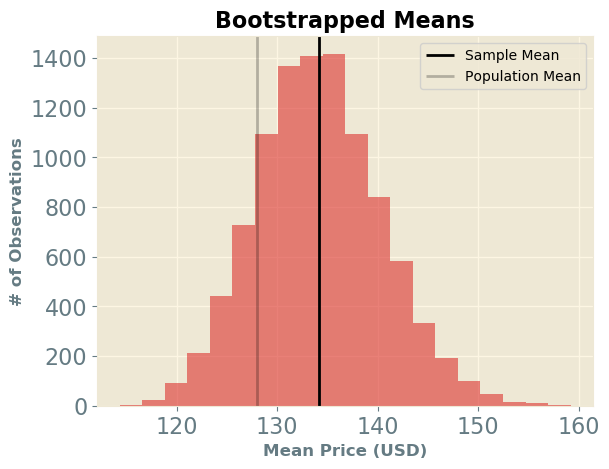

134.15409033333333

In [38]:
num_sims = 10000
sample_means = [NaN for _ in 1:num_sims]
for i in 1:num_sims
    ids_to_sample = sample(1:num_samples, num_samples, replace=true)
    sample_means[i] = mean(sampled_prices[ids_to_sample])
end
figure()
hist(sample_means, alpha=0.6, bins=20, color="C5")
title("Bootstrapped Means", weight="bold")
xlabel("Mean Price (USD)", weight="bold")
ylabel("# of Observations", weight="bold")
axvline(actual_sample_mean, color="k", label="Sample Mean")
axvline(pop_mean, alpha=0.25, color="k", label="Population Mean")
legend(fontsize=10)
print(mean(sample_means))

the above is the **bootstrap empirical distribution of the sample mean** price of Airbnb's in Seattle. its spread quantifies the uncertainty in our estimated mean Airbnb price in Seattle. a wide spread implies that the mean Airbnb price varies dramatically from sample to sample (owing, e.g. to small sample size). 

for reference, we plotted the population mean as the red line, which in practice we wouldn't know, but have the convenience of knowing here since we took this random sample from the population in the first part of our notebook. satisfactorily, the bootstrap empirical distribution exhibits significant density at the true population mean.

instead of reporting our **point estimate** of the mean price, `estimated_mean_airbnb_price`, we can report an **interval estimate** of the mean price defined to be the interval of Airbnb prices such that e.g., 95% of bootstrap sample means fall in this interval. more specifically, 2.5% of bootstrap sample means fall to the left of the interval, and 2.5% of bootstrap sample means fall to the right of the interval. we obtain the interval estimate by computing the 2.5% percentile and 97.5% percentile of the list of bootstrap sample means, `bootstrap_mean_prices`.

In [42]:
confidence = 0.95
alpha = 100 * (1 - confidence) / 2
low_price_estimate = percentile(sample_means, alpha)
high_price_estimate = percentile(sample_means, 100 - alpha)
low_price_estimate, high_price_estimate, alpha

(122.70991666666666, 147.03333333333333, 2.500000000000002)

instead of providing a point estimate, the interval estimate indicates a range of Airbnb prices that reflect our uncertainty owing to random sampling. drawing a random sample of this size from the population and obtaining a mean outside this interval is unlikely.

let's plot the interval estimate on the bootstrap empirical distribution of the sample mean. satisfactorily, we see that this interval estimate includes the mean Airbnb price of the population.

precisely, we can say that, if we were to randomly sample `nb_sample` Airbnb's over and over and compute the mean price from the random sample, we estimate that, 97.5% of the time, the mean price will be higher than `low_price_estimate` and, 97.5% of the time, the mean price will be lower than `high_price_estimate`. this gives us an idea of how much our estimate of the mean could vary from sample to sample. We call this the 95% **confidence interval**. as a warning, bootstrap does not work very well when the sample size is small (e.g. less than 15) since then the empirical sample distribution is not likely to resemble the population distribution.